In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

class Utilities:
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model

    def sanity_check(self, sentence, block_size, model_name='CLS'):
        # Encode the sentence using the tokenizer
        wordids = self.tokenizer.encode(sentence)
         # Display input tensor shape
        n_token = len(wordids)
        tokens = np.array(self.tokenizer.decode_list(wordids))
        print("Number of input tokens:", n_token)
        

        # Prepare the padded input for the model
        padded_sentence = wordids[:block_size] + [0] * (block_size - len(wordids))
        input_tensor = torch.tensor(padded_sentence, dtype=torch.long).unsqueeze(0)

        # Process the input tensor through the encoder model
        if model_name == 'CLS':
            _ = self.model(input_tensor) # Ignore the output of the model, and only get the attention maps; make sure your encoder returns the attention maps
        else:
            _ = self.model(input_tensor, torch.empty_like(input_tensor))
            
        attn_maps = self.model.Ms

        n_layer, n_head, n_batch, bs, bs = attn_maps.shape

        # Display the number of attention maps
        print("Number of attention maps:", n_layer * n_head * n_batch)

        # Visualize and save the attention maps
        for layer in range(n_layer):
            for head in range(n_head):
                attn_map = attn_maps[layer, head, 0]
                att_map = attn_map.detach().cpu().numpy()  # Remove batch dimension and convert to NumPy array

                if n_token < block_size:
                    att_map = att_map[:n_token, :n_token]
                elif n_token > block_size:
                    tokens = tokens[:block_size]

                # Check if the attention probabilities sum to 1 over rows
                total_prob_over_rows = torch.sum(attn_map, dim=1)
                if torch.any(total_prob_over_rows < 0.99) or torch.any(total_prob_over_rows > 1.01):
                    print("Failed normalization test: probabilities do not sum to 1.0 over rows")
                    print("Total probability over rows:", total_prob_over_rows.numpy())

                # Create a heatmap of the attention map
                fig, ax = plt.subplots()
                ax.set_xticks(np.arange(n_token))
                ax.set_yticks(np.arange(n_token))
                ax.set_xticklabels(tokens)
                ax.set_yticklabels(tokens)

                # Rotate x-axis labels
                for tick in ax.get_xticklabels():
                    tick.set_rotation(45)  # Rotate labels by 45 degrees
                    tick.set_ha('right')   # Set horizontal alignment to 'right'

                cax = ax.imshow(att_map, cmap='hot', interpolation='nearest')
                # ax.xaxis.tick_top()  
                fig.colorbar(cax, ax=ax)  
                plt.title(f"{model_name} Attention Map layer {layer}, head {head}")
                
                # Save the plot
                plt.savefig(f"{model_name}_attention_map_layer{layer}_head{head}.png")
                
                # Show the plot
                plt.show()


In [2]:
def load_checkpoint(model, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])

In [3]:
import os
def load_texts(directory):
    """
    This function loads all texts from the specified directory, ignoring any files with "test" in their name. The text is used for "training" the tokenizer. Since our tokenizer is simple, we don't need to do any training, but we still need to ignore the test data. 
    """

    texts = []
    files = os.listdir(directory)
    for filename in files: 
        if "test" in filename:  ## don't "read test files"
            continue
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read()) # train_CLS.tsv, train_LM.txt
    return texts

### Attention Matrices Visualization for CLS

In [4]:
batch_size = 16  # Number of independent sequences  we will process in parallel
block_size = 32  # Maximum context length for predictions
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension
n_head = 2  # Number of attention heads
n_layer = 4  # Number of transformer layers
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes

In [5]:
from tokenizer import SimpleTokenizer
texts = load_texts('speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data

### Generate Heat Map for attentions in CLS Model

In [ ]:
from transformer import CLSModel
model =  CLSModel(vocab_size=tokenizer.vocab_size, n_embd=n_embd, n_head=n_head, block_size=block_size, n_layer=n_layer, n_classes=n_output, n_hidden=n_hidden)

load_checkpoint(model, 'CLS_model.pth')

In [ ]:
utility = Utilities(tokenizer=tokenizer, model=model)

sentence = "Is it any wonder that I am optimistic?"
utility.sanity_check(sentence=sentence, block_size=block_size, model_name='CLS')

### Generate Heat Map for attentions in LM Model

In [ ]:
from transformer import LanguageModel
model =  LanguageModel(vocab_size=tokenizer.vocab_size, n_embd=n_embd, n_head=n_head, block_size=block_size, n_layer=n_layer, n_hidden=n_hidden)

load_checkpoint(model, 'ckpt/LM_model.pth')

In [ ]:
utility = Utilities(tokenizer=tokenizer, model=model)

sentence = "This violence is splitting Baghdad into sectarian enclaves, and shaking the confidence of all Iraqis."
utility.sanity_check(sentence=sentence, block_size=block_size, model_name='LM')

### Generate Heat Map for attentions for DeBERTa

In [ ]:
from transformer import DeBERTa
model =  DeBERTa(vocab_size=tokenizer.vocab_size, n_embd=n_embd, n_head=n_head, block_size=block_size, n_layer=n_layer, n_hidden=n_hidden)

load_checkpoint(model, 'ckpt/DeBERTa_model.pth')

In [ ]:
utility = Utilities(tokenizer=tokenizer, model=model)

sentence = "This violence is splitting Baghdad into sectarian enclaves, and shaking the confidence of all Iraqis."
utility.sanity_check(sentence=sentence, block_size=block_size, model_name='DeBERTa')

### Generate Heat Map for attentions for ALiBi

In [6]:
from transformer import ALiBi
model =  ALiBi(vocab_size=tokenizer.vocab_size, n_embd=n_embd, n_head=n_head, block_size=block_size, n_layer=n_layer, n_hidden=n_hidden)

load_checkpoint(model, 'ckpt/ALiBi_model.pth')

Number of input tokens: 17
use bias
use bias
use bias
use bias
use bias
use bias
use bias
use bias
Number of attention maps: 8


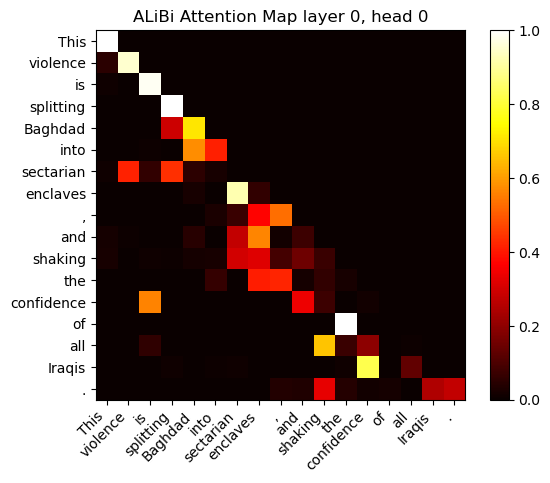

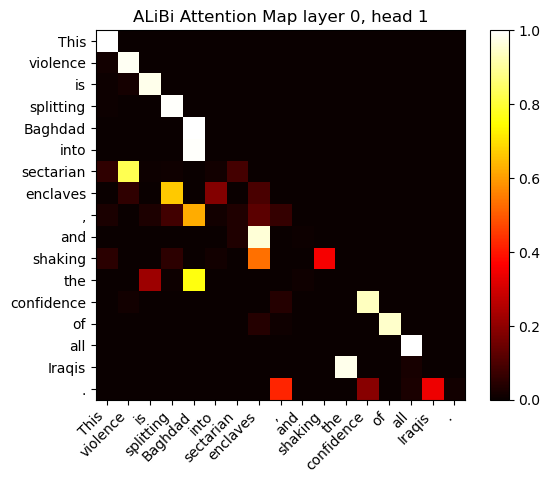

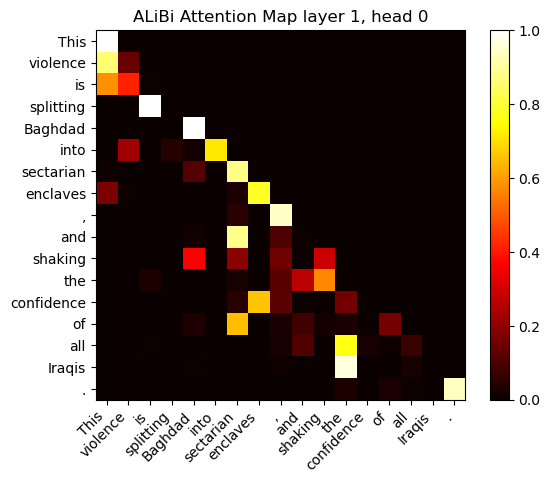

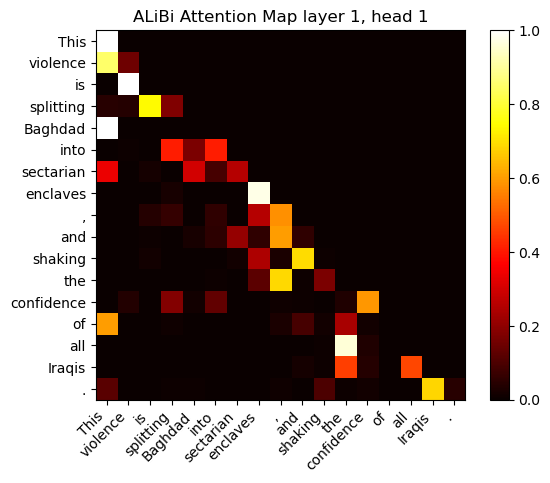

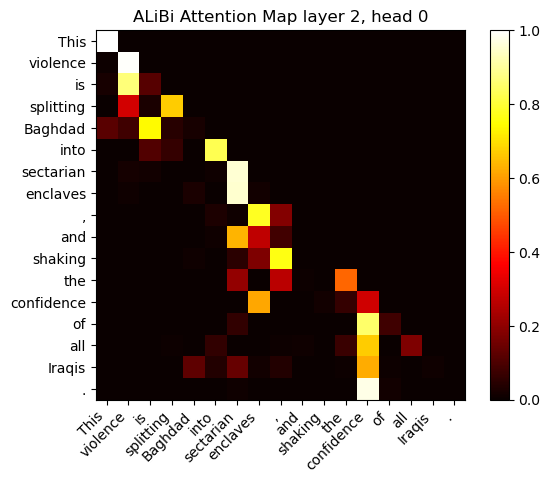

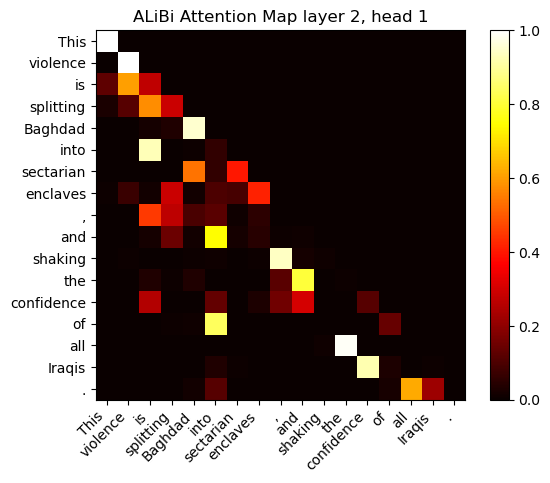

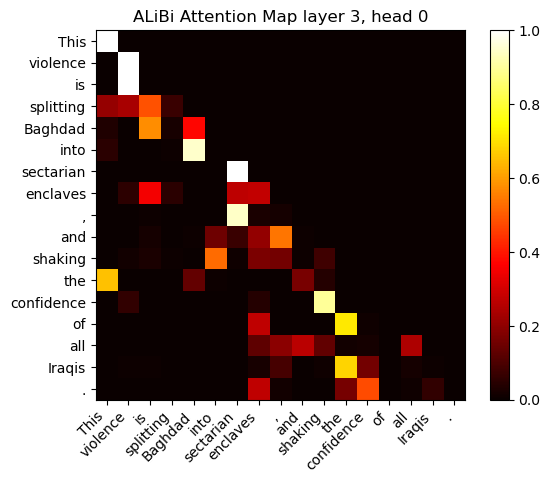

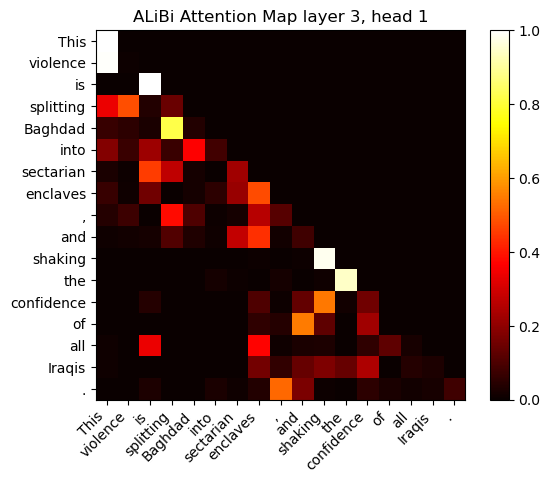

In [8]:
utility = Utilities(tokenizer=tokenizer, model=model)

sentence = "This violence is splitting Baghdad into sectarian enclaves, and shaking the confidence of all Iraqis."
utility.sanity_check(sentence=sentence, block_size=block_size, model_name='ALiBi')